In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### Importing the product reviews data.

In [3]:
product_reviews = pd.read_csv('reviews.csv')

In [4]:
product_reviews.head()

,asin,name,date,rating,review
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...


In [5]:
product_reviews.shape

(2782, 5)

In [6]:
product_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   asin    2782 non-null   object
 1   name    2782 non-null   object
 2   date    2782 non-null   object
 3   rating  2782 non-null   int64 
 4   review  2778 non-null   object
dtypes: int64(1), object(4)
memory usage: 108.8+ KB


# Missing Values

In [7]:
missing = pd.concat([product_reviews.isnull().sum(), 100 * product_reviews.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by=['count', '%'],ascending=True)

,count,%
asin,0,0.000000
name,0,0.000000
date,0,0.000000
rating,0,0.000000
review,4,0.143781


In [8]:
product_reviews.dropna(inplace=True)

In [9]:
product_reviews.shape

(2778, 5)

#### List of Unique Products

In [10]:
product_reviews['name'].nunique()

122

That is, we have a total of 122 unique products in the data set provided.

Number of reviews for each product 

In [11]:
product_reviews['name'].value_counts().head()

Tata-Tea-Gold-500g                               58
MYSORE-SANDAL-Mysore-Sandal-Talcum               40
Dettol-Disinfectant-Cleaner-Home-Fresh           40
Cinthol-Lime-Soap-100-Pack                       40
Mamaearth-Natural-Turmeric-Saffron-brightning    40
Name: name, dtype: int64

### Now we will try to find the unique brands that these products belong to and the number of reviews each brand has. We can do this as we can see a pattern in the name and extracting the first word would give us the brand associated with the product.

In [12]:
product_reviews['brandName'] = product_reviews['name'].str.split('-').str[0]
product_reviews.head()

,asin,name,date,rating,review,brandName
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...,Mamaearth
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...,Mamaearth
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...,Mamaearth
3,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-16,1,Product just smells similar to navarathna hair...,Mamaearth
4,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-18,5,I have been trying different onion oil for my ...,Mamaearth


In [13]:
product_reviews['brandName'].unique()

array(['Mamaearth', 'Godrej', 'Titan', 'Maaza', 'Paper', 'Indiana',
       'Coca', 'Natural', 'Maggi', 'Glucon', 'Amul', 'Patanjali',
       'PATANJALI', 'Dettol', 'Savlon', 'Cinthol', 'Britannia',
       'NutriChoice', 'Streax', 'Himalaya', 'Society', 'Tata', 'Fastrack',
       'Reflex', 'MYSORE', 'Mysore'], dtype=object)

In [14]:
product_reviews['brandName'] = product_reviews['brandName'].str.replace('PATANJALI', 'Patanjali')
product_reviews['brandName'] = product_reviews['brandName'].str.replace('MYSORE', 'Mysore')

In [15]:
product_reviews['brandName'].nunique()

24

#### There are a total of 24 unique brands that have their product reviews in the dataset

In [23]:
product_reviews['brandName'].value_counts().head()

Cinthol      200
Himalaya     200
Mamaearth    200
Titan        200
Godrej       200
Name: brandName, dtype: int64

# Ratings for the top 5 Brands

In [36]:
cinthol_rat = product_reviews[product_reviews['brandName']=='Cinthol']
him_rat = product_reviews[product_reviews['brandName']=='Himalaya']
mam_rat = product_reviews[product_reviews['brandName']=='Mamaearth']
tit_rat = product_reviews[product_reviews['brandName']=='Titan']
god_rat = product_reviews[product_reviews['brandName']=='Godrej']

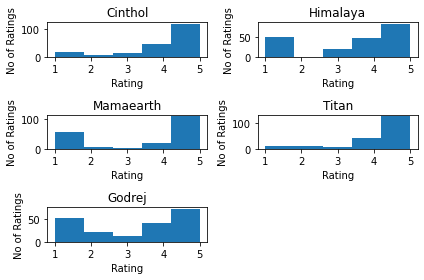

In [40]:
plt.subplot(3,2,1)
plt.hist(cinthol_rat['rating'],bins=5)
plt.title('Cinthol')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,2)
plt.hist(him_rat['rating'],bins=5)
plt.title('Himalaya')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,3)
plt.hist(mam_rat['rating'],bins=5)
plt.title('Mamaearth')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,4)
plt.hist(tit_rat['rating'],bins=5)
plt.title('Titan')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,5)
plt.hist(god_rat['rating'],bins=5)
plt.title('Godrej')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')

plt.tight_layout()
plt.show()


# Ratings of the bottom 5 Brands

In [41]:
product_reviews['brandName'].value_counts().tail()

Maggi          20
Maaza          20
Savlon         20
NutriChoice    12
Indiana         6
Name: brandName, dtype: int64

In [45]:
mag_rat = product_reviews[product_reviews['brandName']=='Maggi']
maaz_rat = product_reviews[product_reviews['brandName']=='Maaza']
sav_rat = product_reviews[product_reviews['brandName']=='Savlon']
nutri_rat = product_reviews[product_reviews['brandName']=='NutriChoice']
ind_rat = product_reviews[product_reviews['brandName']=='Indiana']

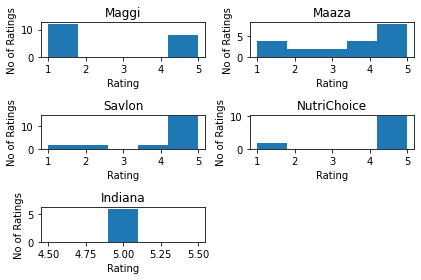

In [46]:
plt.subplot(3,2,1)
plt.hist(mag_rat['rating'],bins=5)
plt.title('Maggi')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,2)
plt.hist(maaz_rat['rating'],bins=5)
plt.title('Maaza')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,3)
plt.hist(sav_rat['rating'],bins=5)
plt.title('Savlon')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,4)
plt.hist(nutri_rat['rating'],bins=5)
plt.title('NutriChoice')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')


plt.subplot(3,2,5)
plt.hist(ind_rat['rating'],bins=5)
plt.title('Indiana')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')

plt.tight_layout()
plt.show()

# overall rating for entire range of indian products

Text(0, 0.5, 'No of Ratings')

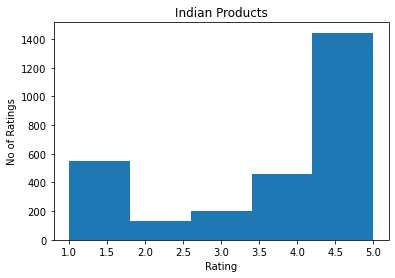

In [53]:
plt.hist(product_reviews['rating'],bins=5)
plt.title('Indian Products')
plt.xlabel('Rating')
plt.ylabel('No of Ratings')

# Percent of customers completely satisfied

In [60]:
star_5 = product_reviews[product_reviews['rating']==5]
per_5 = (star_5['rating'].count()/len(product_reviews))*100

In [62]:
print(per_5)

51.97984161267099


That is 51% customers have given a 5 star rating overall

# Percent of customers not at all satisfied

In [63]:
star_1 = product_reviews[product_reviews['rating']==1]
per_1 = (star_1['rating'].count()/len(product_reviews))*100
print(per_1)

19.654427645788335


That is 19% customers have given a 1 star rating overall